# Modelling
* **Author**: Winnie Zhang
* BrainStation, Data science 
* Next Notebook: 5. Model Interpretation

## Introduction
In the previous notebook, we did initial analysis to explore the relationship between our input and target variables. 

In this notebook, I will start modelling. Since I will be trying to predict a negative (0) or positive (1) sentiment, I will be using classification models.These are the models that I intend to test:
1. Logistic regression (L1 and L2 regularization)
2. Decision trees
3. Support Vector Machines (SVM)

To process my text, I will also use 2 methods to turn them into a numeric form:
1. Bag of words (CountVectorizer)
2. TF-IDF

First, I will load all the libraries I need: 

In [1]:
import joblib
import pandas as pd
import numpy as np

# scipy modules 
from scipy import stats

import matplotlib.pyplot as plt 
import seaborn as sns

# scikit learn modules 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# classifiers
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# for vectorizing
import nltk
import string
nltk.download('stopwords')
# import the nltk stopwords
from nltk.corpus import stopwords 

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## Functions Needed For Modelling

These are some of the functions I will use for when I'm preparing my data for modelling and when I'm modelling.

First, I need to consider when processing the text, if I want to use stemming or lemmatization. I will focus my efforts on stemming as this is more simple than lemmatization.

In [2]:
# tokenizer function for stemming
stemmer = nltk.stem.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

I also want to plot and see some of the most frequent words used. I will use this function to do that: 

In [3]:
# function to plot most frequent words:
def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()

## Load the Dataset
First I will read in the dataset and take a look at the first 5 rows.

In [5]:
df = joblib.load("data/data_final.pkl")

In [3]:
# sanity check
df.head()

,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,...,Action / Dexterity,Movies / TV / Radio theme,Medieval,Players: Two Player Only Games,Crowdfunding: Kickstarter,rating,comment,number_of_reviews_by_user,avg_rating,comment_length
1,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,1,I tend to either love or easily tire of co-op ...,137,6.175182,76
2,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,1,This is an amazing co-op game. I play mostly ...,306,7.035948,62
3,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,1,Hey! I can finally rate this game I've been pl...,1411,5.974841,217
4,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,1,Love it- great fun with my son. 2 plays so far...,96,7.385417,16
5,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,1,"Fun, fun game. Strategy is required, but defin...",7,7.285714,99


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3036278 entries, 1 to 3228554
Data columns (total 47 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   description                     object 
 1   yearpublished                   int64  
 2   minplayers                      int64  
 3   maxplayers                      int64  
 4   minplaytime                     int64  
 5   maxplaytime                     int64  
 6   minage                          int64  
 7   boardgameexpansion              int32  
 8   boardgameimplementation         int32  
 9   usersrated                      int64  
 10  average                         float64
 11  Board Game Rank                 int64  
 12  owned                           int64  
 13  trading                         int64  
 14  wanting                         int64  
 15  wishing                         int64  
 16  numcomments                     int64  
 17  numweights                 

Now, I'm going to split the data into X (features we're interested in) and y (target).

In [5]:
X = df.drop(["rating"], axis=1)
X.head()

,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,...,Miniatures,Action / Dexterity,Movies / TV / Radio theme,Medieval,Players: Two Player Only Games,Crowdfunding: Kickstarter,comment,number_of_reviews_by_user,avg_rating,comment_length
1,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,0,I tend to either love or easily tire of co-op ...,137,6.175182,76
2,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,0,This is an amazing co-op game. I play mostly ...,306,7.035948,62
3,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,0,Hey! I can finally rate this game I've been pl...,1411,5.974841,217
4,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,0,Love it- great fun with my son. 2 plays so far...,96,7.385417,16
5,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,1,1,109006,...,0,0,0,0,0,0,"Fun, fun game. Strategy is required, but defin...",7,7.285714,99


In [6]:
# define y
y = df["rating"]
y.head()

1    1
2    1
3    1
4    1
5    1
Name: rating, dtype: int32

### Sampling

Because the dataset is so large (3 million rows), I'm going to take a sample of the dataset.

In [7]:
X_sample, y_sample = resample(X, y, random_state=0, n_samples=0.017*X.shape[0], replace=False,
                              stratify=y)

In [9]:
print(f'X_sample shape: {X_sample.shape}')
print(f'y_sample shape: {y_sample.shape}')

X_sample shape: (51616, 46)
y_sample shape: (51616,)


### Train Test Split 

In [8]:
# 30% for test set 
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3,
                                                    random_state=1)

Now, I'm going to save this into a folder.

**NOTE**: I'm not saving this as a `.csv` file and as a `.pkl` file instead because I personally had issues with working with `.csv` files while uploading them, as they would randomly add in Null values to the comments and descriptions.

In [10]:
joblib.dump(X_train, "train_test_split/X_train.pkl")
joblib.dump(y_train, "train_test_split/y_train.pkl")
joblib.dump(X_test, "train_test_split/X_test.pkl")
joblib.dump(y_test, "train_test_split/y_test.pkl")

['train_test_split/y_test.pkl']

In [7]:
X_train = joblib.load("train_test_split/X_train.pkl")
y_train = joblib.load("train_test_split/y_train.pkl")
X_test = joblib.load("train_test_split/X_test.pkl")
y_test = joblib.load("train_test_split/y_test.pkl")

## Bag of Words

First, I will vectorize my text using `CountVectorizer`, also known as Bag of Words. Count Vectorizer transforms the given text using the number of counts/frequency a word appears in the text.

### Vectorizing Comment
First, I will take a look at a simple CountVectorizer on `comment`.

In [29]:
# 1. instantiate the model
bagofwords_comment = CountVectorizer()

# 2. fit the model 
bagofwords_comment.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment = bagofwords_comment.transform(X_train["comment"])
bow_train_transformed_comment.shape

(36131, 31281)

There's over 31,000 tokesn! I will take a look at some of the most frequent words:

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


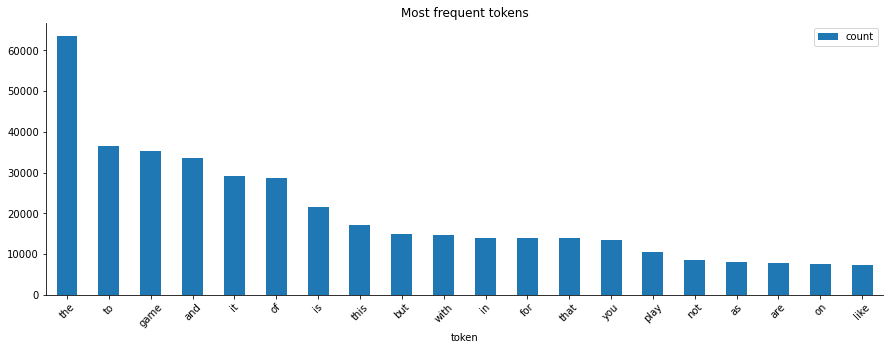

In [32]:
words = bagofwords_comment.get_feature_names()
word_counts = bow_train_transformed_comment.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

The most frequent words are stop words. THis doesn't really help us with understanding the text. I will use `my_tokenizer` to help remove these.

In [35]:
# 1. instantiate the model
bagofwords_comment2 = CountVectorizer(tokenizer=my_tokenizer)

# 2. fit the model 
bagofwords_comment2.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment2 = bagofwords_comment2.transform(X_train["comment"])
bow_train_transformed_comment2.shape

(36131, 28931)

Even with the removal of stop words, there's almost 29,000 tokens. That's still too many. I will set the `min_df` to remove words that only a occur a few times as it doesn't represent a trend. I also want to look at `n_grams`, which includes 2 words being together as only looking at 1 word means it can lose the meaning (e.g. we can lose the negation, meaning the texxt appears to indicate a positive feeling when it should be negative).

In [36]:
# 1. instantiate the model
bagofwords_comment3 = CountVectorizer(min_df=5, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3))

# 2. fit the model 
bagofwords_comment3.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment3 = bagofwords_comment3.transform(X_train["comment"])
bow_train_transformed_comment3.shape

(36131, 26543)

After removing the stop words, I will look at the most frequent words again: 

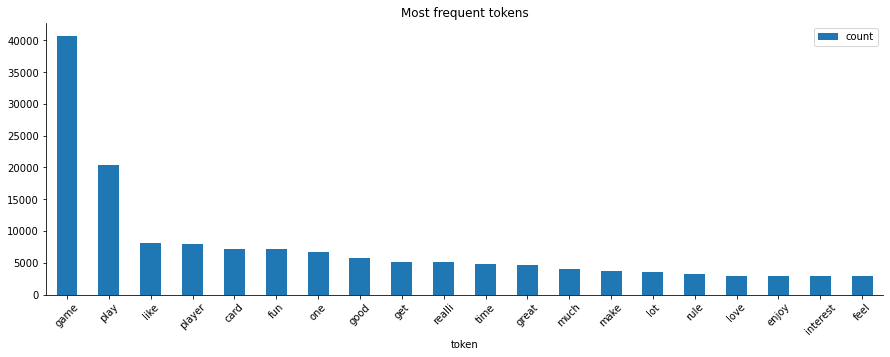

In [37]:
words = bagofwords_comment3.get_feature_names()
word_counts = bow_train_transformed_comment3.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

This adds a lot more context. For example, "card" seems to be a popular word, suggesting that there's a lot of card games or people might enjoy card games.

However, this is still a lot of words so I will continue vectorizing until I'm happy with the number of tokens.

In [38]:
# 1. instantiate the model
bagofwords_comment4 = CountVectorizer(min_df=10, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3))

# 2. fit the model 
bagofwords_comment4.fit(X_train["comment"])

# 4. transform
bow_train_transformed_comment4 = bagofwords_comment4.transform(X_train["comment"])
bow_train_transformed_comment4.shape

(36131, 11545)

In [39]:
# 1. instantiate the model
bagofwords_comment5 = CountVectorizer(min_df=15, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3))

# 2. fit the model 
bagofwords_comment5.fit(X_train["comment"])

# 5. transform
bow_train_transformed_comment5 = bagofwords_comment5.transform(X_train["comment"])
bow_train_transformed_comment5.shape

(36131, 7520)

In [40]:
# 1. instantiate the model
bagofwords_comment6 = CountVectorizer(min_df=20, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3))

# 2. fit the model 
bagofwords_comment6.fit(X_train["comment"])

# 6. transform
bow_train_transformed_comment6 = bagofwords_comment6.transform(X_train["comment"])
bow_train_transformed_comment6.shape

(36131, 5657)

In [41]:
# 1. instantiate the model
bagofwords_comment7 = CountVectorizer(min_df=25, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3))

# 2. fit the model 
bagofwords_comment7.fit(X_train["comment"])

# 7. transform
bow_train_transformed_comment7 = bagofwords_comment7.transform(X_train["comment"])
bow_train_transformed_comment7.shape

(36131, 4541)

I will add `max_df` to help remove the very common words and see if this reduces the number of tokens.

In [42]:
# 1. instantiate the model
bagofwords_comment8 = CountVectorizer(min_df=20, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3),
                                      max_df=4000)

# 2. fit the model 
bagofwords_comment8.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment8 = bagofwords_comment8.transform(X_train["comment"])
bow_train_transformed_comment8.shape

(36131, 5646)

In [44]:
# 1. instantiate the model
bagofwords_comment9 = CountVectorizer(min_df=25, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3),
                                      max_df=3000)

# 2. fit the model 
bagofwords_comment9.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment9 = bagofwords_comment9.transform(X_train["comment"])
bow_train_transformed_comment9.shape

(36131, 4526)

The number of tokens doesn't appear to change much. Therefore, I won't use it and instead, use `max_features` to limit the number of tokesn I'm looking at to 3000 so that my dataframe doesn't get too large.

In [8]:
# 1. instantiate the model
bagofwords_comment10 = CountVectorizer(min_df=20, 
                                      tokenizer=my_tokenizer,
                                      ngram_range=(1,3),
                                      max_features=3000)

# 2. fit the model 
bagofwords_comment10.fit(X_train["comment"])

# 3. transform
bow_train_transformed_comment10 = bagofwords_comment10.transform(X_train["comment"])
bow_train_transformed_comment10.shape

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(36131, 3000)

3000 is a good number of tokens. I will now plot this to see the most common words.

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


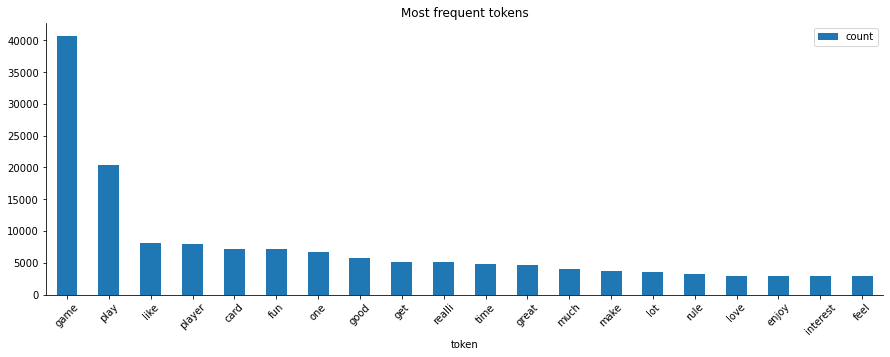

In [9]:
words = bagofwords_comment10.get_feature_names()
word_counts = bow_train_transformed_comment10.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

The most common words include words liek "card", "fun", "good", and "great".

I'm now done vectorizing and can change this to a dense array.

#### Converting to a Dense Array

In [46]:
bow_comment_train_df = pd.DataFrame(columns=bagofwords_comment10.get_feature_names(), 
                                   data=bow_train_transformed_comment10.toarray())
bow_comment_train_df.head()

,0,1,1 2,1 play,10,10 minut,100,11,12,13,...,yet play,youd,youll,young,younger,your,youv,youv got,zero,zombi
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will rename the column name to include the word `reviews` to indicate that this word is form the `comment` column as later on, the `description` column may contain overlapping words.

In [50]:
# rename
bow_comment_train_df.columns = ["review_" + column for column in bow_comment_train_df.columns]
bow_comment_train_df.head()

,review_0,review_1,review_1 2,review_1 play,review_10,review_10 minut,review_100,review_11,review_12,review_13,...,review_yet play,review_youd,review_youll,review_young,review_younger,review_your,review_youv,review_youv got,review_zero,review_zombi
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will now transform the test dataset, make it into a dataframe, and change the column names.

In [47]:
bow_test_transformed_comment = bagofwords_comment10.transform(X_test["comment"])
bow_test_transformed_comment.shape

(15485, 3000)

In [48]:
bow_comment_test_df = pd.DataFrame(columns=bagofwords_comment10.get_feature_names(), 
                                   data=bow_test_transformed_comment.toarray())
bow_comment_test_df.head()

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,1 2,1 play,10,10 minut,100,11,12,13,...,yet play,youd,youll,young,younger,your,youv,youv got,zero,zombi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# rename
bow_comment_test_df.columns = ["review_" + column for column in bow_comment_test_df.columns]
bow_comment_test_df.head()

,review_0,review_1,review_1 2,review_1 play,review_10,review_10 minut,review_100,review_11,review_12,review_13,...,review_yet play,review_youd,review_youll,review_young,review_younger,review_your,review_youv,review_youv got,review_zero,review_zombi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Vectorizing Description
Now, I will CountVectorize the `description` column. I will once again play around with the different features until I'm happy with the number of tokens.

In [52]:
# 1. instantiate the model
bagofwords_description = CountVectorizer(min_df=5,
                                         tokenizer=my_tokenizer,
                                         ngram_range=(1,3))

# _description. fit the model 
bagofwords_description.fit(X_train["description"])

# 3. transform
bow_train_transformed_description = bagofwords_description.transform(X_train["description"])
bow_train_transformed_description.shape

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(36131, 417055)

In [53]:
# 1. instantiate the model
bagofwords_description2 = CountVectorizer(min_df=10,
                                          tokenizer=my_tokenizer,
                                          ngram_range=(1,3))

# _description. fit the model 
bagofwords_description2.fit(X_train["description"])

# 3. transform
bow_train_transformed_description2 = bagofwords_description2.transform(X_train["description"])
bow_train_transformed_description2.shape

(36131, 219544)

In [54]:
# 1. instantiate the model
bagofwords_description3 = CountVectorizer(min_df=15,
                                          tokenizer=my_tokenizer,
                                          ngram_range=(1,3))

# _description. fit the model 
bagofwords_description3.fit(X_train["description"])

# 3. transform
bow_train_transformed_description3 = bagofwords_description3.transform(X_train["description"])
bow_train_transformed_description3.shape

(36131, 147094)

In [55]:
# 1. instantiate the model
bagofwords_description4 = CountVectorizer(min_df=20,
                                          tokenizer=my_tokenizer,
                                          ngram_range=(1,3))

# _description. fit the model 
bagofwords_description4.fit(X_train["description"])

# 3. transform
bow_train_transformed_description4 = bagofwords_description4.transform(X_train["description"])
bow_train_transformed_description4.shape

(36131, 111484)

In [56]:
# 1. instantiate the model
bagofwords_description5 = CountVectorizer(min_df=20,
                                          tokenizer=my_tokenizer,
                                          max_df=3000)

# 5. fit the model 
bagofwords_description5.fit(X_train["description"])

# 3. transform
bow_train_transformed_description5 = bagofwords_description5.transform(X_train["description"])
bow_train_transformed_description5.shape

(36131, 10852)

I will limit the number of features used by using `max_fatures` to ensure that my dataset doesn't get too big.

In [10]:
# 1. instantiate the model
bagofwords_description6 = CountVectorizer(min_df=20,
                                          tokenizer=my_tokenizer,
                                          max_features=3000)

# 6. fit the model 
bagofwords_description6.fit(X_train["description"])

# 3. transform
bow_train_transformed_description6 = bagofwords_description6.transform(X_train["description"])
bow_train_transformed_description6.shape

(36131, 3000)

I will also visualize the most common words.

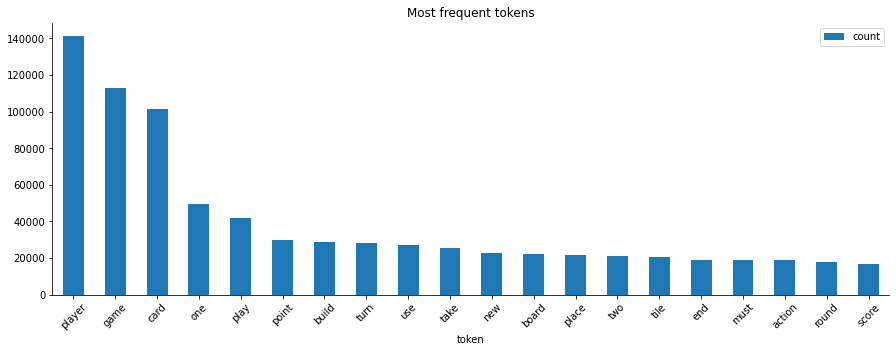

In [11]:
words = bagofwords_description6.get_feature_names()
word_counts = bow_train_transformed_description6.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

Similar to comment, the word "card' is common. Other interesting common words include "build" and "action".

I'm happy with this and will now convert this to a dense matrix so it can be concatenated onto `X_train`.

#### Convert to Dense Matrix
Now that I'm satisfied with the number of tokens, I will convert this to a dense matrix so I can concatenate it to other dataframes.

In [66]:
bow_description_train_df = pd.DataFrame(columns=bagofwords_description6.get_feature_names(), 
                                   data=bow_train_transformed_description6.toarray())
bow_description_train_df.head()

,0,1,10,100,1000,1010,101010,10the,11,110,...,yoursquol,yoursquor,youv,zero,ziggurat,zman,zombi,zombicid,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will rename the column to include `descrip_` in front of the column name so that we know this comes from the description column and not the comment column.

In [67]:
# rename
bow_description_train_df.columns = ["descrip_" + column for column in bow_description_train_df.columns]
bow_description_train_df.head()


,descrip_0,descrip_1,descrip_10,descrip_100,descrip_1000,descrip_1010,descrip_101010,descrip_10the,descrip_11,descrip_110,...,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zman,descrip_zombi,descrip_zombicid,descrip_zone,descrip_zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will now transform the test set, and convert this to a dense matrix, and rename the columns.

In [68]:
bow_test_transformed_description = bagofwords_description6.transform(X_test["description"])
bow_test_transformed_description.shape

(15485, 3000)

In [69]:
bow_description_test_df = pd.DataFrame(columns=bagofwords_description6.get_feature_names(), 
                                   data=bow_test_transformed_description.toarray())
bow_description_test_df.head()

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,10,100,1000,1010,101010,10the,11,110,...,yoursquol,yoursquor,youv,zero,ziggurat,zman,zombi,zombicid,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# rename
bow_description_test_df.columns = ["descrip_" + column for column in bow_description_test_df.columns]
bow_description_test_df.head()

,descrip_0,descrip_1,descrip_10,descrip_100,descrip_1000,descrip_1010,descrip_101010,descrip_10the,descrip_11,descrip_110,...,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zman,descrip_zombi,descrip_zombicid,descrip_zone,descrip_zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Concatenate to X_train and X_test

Now, I will concatenate the dataframes onto `X_train` and `X_test` so that we can use them for when we model.

In [71]:
# concatenate them all together 
X_train_bow =  pd.concat([X_train, bow_comment_train_df.set_index(X_train.index),
                       bow_description_train_df.set_index(X_train.index)], axis=1)

Now, I will drop the description and comment column as they're not needed anymore.

In [82]:
X_train_bow.drop(["description", "comment"], axis=1, inplace=True)

In [84]:
X_train_bow.head()

,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,average,...,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zman,descrip_zombi,descrip_zombicid,descrip_zone,descrip_zoo
2372555,2009,3,6,120,120,12,0,0,1185,6.61042,...,0,0,0,0,0,0,0,0,0,0
2395149,2016,2,8,15,15,8,0,0,1130,6.10510,...,0,0,0,0,0,0,0,0,0,0
282401,2014,2,5,60,120,13,1,0,41405,7.54132,...,0,0,0,0,0,0,0,0,0,0
221641,2007,2,4,30,60,12,1,1,48919,7.75712,...,0,0,0,0,0,0,0,0,0,0
2234324,2005,2,3,60,90,10,0,0,1600,6.78740,...,0,0,0,0,0,0,0,0,0,0


In [72]:
X_test_bow = pd.concat([X_test, bow_comment_test_df.set_index(X_test.index),
                       bow_description_test_df.set_index(X_test.index)], axis=1)

In [83]:
X_test_bow.drop(["description", "comment"], axis=1, inplace=True)

In [85]:
X_test_bow.head()

,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,average,...,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zman,descrip_zombi,descrip_zombicid,descrip_zone,descrip_zoo
820189,2019,1,100,30,45,10,1,0,16729,7.71772,...,0,0,0,0,0,0,0,0,0,0
232923,2017,1,4,60,120,14,1,0,47853,8.74356,...,0,0,0,0,0,0,0,0,0,0
2928001,2008,2,4,30,30,0,0,0,232,6.34698,...,0,0,0,0,0,0,0,0,0,0
1521298,2000,1,6,30,30,11,1,1,5384,6.19540,...,0,0,0,0,0,0,0,0,0,0
2887032,2002,3,5,90,90,10,0,0,271,6.05683,...,0,0,0,0,0,0,0,0,0,0


In [88]:
joblib.dump(X_train_bow, "train_test_split/X_train_bow.pkl")
joblib.dump(X_test_bow, "train_test_split/X_test_bow.pkl")

['train_test_split/y_test.pkl']

In [6]:
X_train_bow = joblib.load("train_test_split/X_train_bow.pkl")
X_test_bow = joblib.load("train_test_split/X_test_bow.pkl")
y_train = joblib.load("train_test_split/y_train.pkl")
y_test = joblib.load("train_test_split/y_test.pkl")

## TF-IDF Vectorization
Now, I will vectorize using TF-IDF for both `comment` and `description` so I can see how the models compare to using Bag of Words.

#### Vectorizing Comment

First, I will vectorize TF-IDF for comment: 

In [10]:
tfidf_comment = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer)
tfidf_comment.fit(X_train["comment"])

tfidf_train_transformed_comment = tfidf_comment.transform(X_train["comment"])
tfidf_train_transformed_comment.shape

(36131, 6124)

I should also use `n_grams` to consider when 2 words are used together.

In [11]:
tfidf_comment2 = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_comment2.fit(X_train["comment"])

tfidf_train_transformed_comment2 = tfidf_comment2.transform(X_train["comment"])
tfidf_train_transformed_comment2.shape

(36131, 26543)

That's a lot of tokens so I will start changing `min_df` to a higher threshold to eliminate words only used a few times.

In [12]:
tfidf_comment3 = TfidfVectorizer(min_df=10,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_comment3.fit(X_train["comment"])

tfidf_train_transformed_comment3 = tfidf_comment3.transform(X_train["comment"])
tfidf_train_transformed_comment3.shape

(36131, 11545)

In [13]:
tfidf_comment4 = TfidfVectorizer(min_df=15,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_comment4.fit(X_train["comment"])

tfidf_train_transformed_comment4 = tfidf_comment4.transform(X_train["comment"])
tfidf_train_transformed_comment4.shape

(36131, 7520)

Because I don't want to there to be more than 3000 features or else the dataframe will get too big, I will set `max_features=3000`.

In [12]:
tfidf_comment5 = TfidfVectorizer(min_df=15,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3),
                        max_features=3000)
tfidf_comment5.fit(X_train["comment"])

tfidf_train_transformed_comment5 = tfidf_comment5.transform(X_train["comment"])
tfidf_train_transformed_comment5.shape

(36131, 3000)

I will now plot the most frequent words.

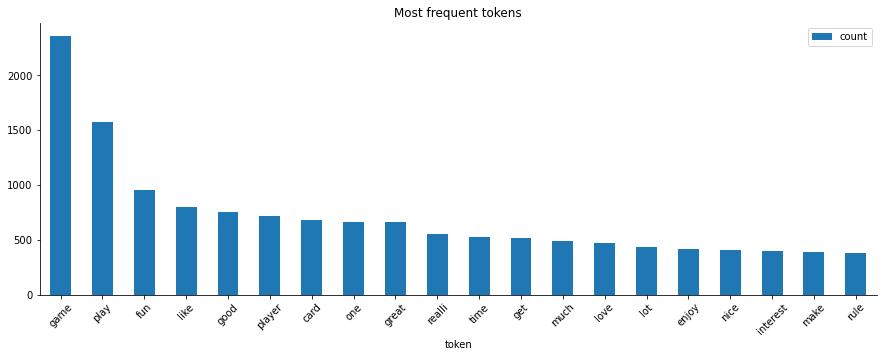

In [13]:
words = tfidf_comment5.get_feature_names()
word_counts = tfidf_train_transformed_comment5.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

Similarly, the word with the highest count is "game" and the word "card". However, the word "fun" now also ranks high.

Now, I will transform the test dataset.

In [22]:
tfidf_test_transformed_comment = tfidf_comment5.transform(X_test["comment"])

#### Convert to Dense Matrix
Next, I will take all my vectorization and covert them to dense matrices so they can be concatenated to `X_train` and `X_test`.

In [16]:
tfidf_comment_train_df = pd.DataFrame(columns=tfidf_comment5.get_feature_names(), 
                                   data=tfidf_train_transformed_comment5.toarray())
tfidf_comment_train_df.head()

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,1 2,1 play,10,10 minut,100,11,12,13,...,yet,yet play,youd,youll,young,younger,your,youv,zero,zombi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118515,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207109
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
tfidf_comment_train_df.columns = ["review_" + column for column in tfidf_comment_train_df.columns]
tfidf_comment_train_df.head()

,review_0,review_1,review_1 2,review_1 play,review_10,review_10 minut,review_100,review_11,review_12,review_13,...,review_yet,review_yet play,review_youd,review_youll,review_young,review_younger,review_your,review_youv,review_zero,review_zombi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118515,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207109
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [24]:
tfidf_comment_test_df = pd.DataFrame(columns=tfidf_comment5.get_feature_names(), 
                                   data=tfidf_test_transformed_comment.toarray())
tfidf_comment_test_df.head()

,0,1,1 2,1 play,10,10 minut,100,11,12,13,...,yet,yet play,youd,youll,young,younger,your,youv,zero,zombi
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.230546,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tfidf_comment_test_df.columns = ["review_" + column for column in tfidf_comment_test_df.columns]
tfidf_comment_test_df.head()

,review_0,review_1,review_1 2,review_1 play,review_10,review_10 minut,review_100,review_11,review_12,review_13,...,review_yet,review_yet play,review_youd,review_youll,review_young,review_younger,review_your,review_youv,review_zero,review_zombi
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.230546,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorize Description
Next, I will use TF-IDF to vectorize `description` and try different parameters to ensure there aren't too many tokens.

In [26]:
tfidf_description = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_description.fit(X_train["description"])

tfidf_train_transformed_description = tfidf_description.transform(X_train["description"])

tfidf_train_transformed_description.shape

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(36131, 417055)

In [19]:
tfidf_description2 = TfidfVectorizer(min_df=10,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_description2.fit(X_train["description"])

tfidf_train_transformed_description2 = tfidf_description2.transform(X_train["description"])

tfidf_train_transformed_description2.shape

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(36131, 219544)

In [20]:
tfidf_description3 = TfidfVectorizer(min_df=15,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3))
tfidf_description3.fit(X_train["description"])

tfidf_train_transformed_description3 = tfidf_description3.transform(X_train["description"])

tfidf_train_transformed_description3.shape

(36131, 147094)

To limit the number of tokens, I will set `max_features=3000`.

In [14]:
tfidf_description4 = TfidfVectorizer(min_df=15,
                        tokenizer=my_tokenizer,
                        ngram_range=(1,3),
                        max_features=3000)
tfidf_description4.fit(X_train["description"])

tfidf_train_transformed_description4 = tfidf_description4.transform(X_train["description"])

tfidf_train_transformed_description4.shape

(36131, 3000)

Now, I will graph the most common words.

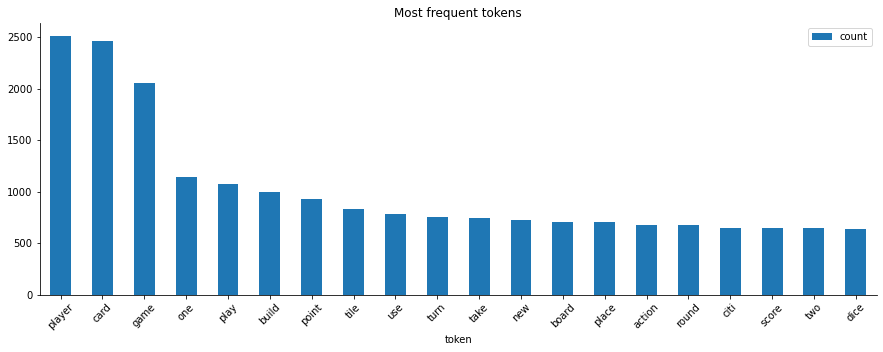

In [15]:
words = tfidf_description4.get_feature_names()
word_counts = tfidf_train_transformed_description4.toarray().sum(axis=0)
plot_most_frequent(words, word_counts)

"Card" is another common word, as seen in the previous cases. 

Now, I will transform the test set.

In [29]:
tfidf_test_transformed_description = tfidf_description4.transform(X_test["description"])

#### Convert to Dense Matrix

In [31]:
tfidf_description_train_df = pd.DataFrame(columns=tfidf_description4.get_feature_names(), 
                                   data=tfidf_train_transformed_description4.toarray())
tfidf_description_train_df.head()

,0,1,1 10,1 10 1010,1 10 11010,1 2,1 point,10,10 1,10 1 10,...,youll need,young,your,yoursquol,yoursquor,youv,zero,ziggurat,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
tfidf_description_train_df.columns = ["descrip_" + column for column in tfidf_description_train_df.columns]
tfidf_description_train_df.head()

,descrip_0,descrip_1,descrip_1 10,descrip_1 10 1010,descrip_1 10 11010,descrip_1 2,descrip_1 point,descrip_10,descrip_10 1,descrip_10 1 10,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
tfidf_description_test_df = pd.DataFrame(columns=tfidf_description4.get_feature_names(), 
                                   data=tfidf_test_transformed_description.toarray())
tfidf_description_test_df.head()

,0,1,1 10,1 10 1010,1 10 11010,1 2,1 point,10,10 1,10 1 10,...,youll need,young,your,yoursquol,yoursquor,youv,zero,ziggurat,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tfidf_description_test_df.columns = ["descrip_" + column for column in tfidf_description_test_df.columns]
tfidf_description_test_df.head()

,descrip_0,descrip_1,descrip_1 10,descrip_1 10 1010,descrip_1 10 11010,descrip_1 2,descrip_1 point,descrip_10,descrip_10 1,descrip_10 1 10,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058733,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# concatenate them all together 
X_train_tfidf =  pd.concat([X_train, tfidf_comment_train_df.set_index(X_train.index),
                       tfidf_description_train_df.set_index(X_train.index)], axis=1)

In [37]:
X_train_tfidf.head()

,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
2372555,Colonia in the Middle Ages. The largest city o...,2009,3,6,120,120,12,0,0,1185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2395149,Knit Wit is a word game along the lines of Sca...,2016,2,8,15,15,8,0,0,1130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282401,&quot;Crossroads&quot; is a game series from P...,2014,2,5,60,120,13,1,0,41405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221641,2018 UPDATE: The second edition of the game is...,2007,2,4,30,60,12,1,1,48919,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2234324,Players take on the role of one of three leade...,2005,2,3,60,90,10,0,0,1600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_train_tfidf.drop(["description", "comment"], axis=1, inplace=True)
X_train_tfidf.head()

,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,average,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
2372555,2009,3,6,120,120,12,0,0,1185,6.61042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2395149,2016,2,8,15,15,8,0,0,1130,6.10510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282401,2014,2,5,60,120,13,1,0,41405,7.54132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221641,2007,2,4,30,60,12,1,1,48919,7.75712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2234324,2005,2,3,60,90,10,0,0,1600,6.78740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_test_tfidf =  pd.concat([X_test, tfidf_comment_test_df.set_index(X_test.index),
                       tfidf_description_test_df.set_index(X_test.index)], axis=1)
X_test_tfidf.head()

,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
820189,Queen Gimnax has ordered the reclamation of th...,2019,1,100,30,45,10,1,0,16729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232923,Gloomhaven is a game of Euro-inspired tactica...,2017,1,4,60,120,14,1,0,47853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928001,"A strategic dice combat game, that pits the 2-...",2008,2,4,30,30,0,0,0,232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521298,"In Chrononauts, each player becomes a time tra...",2000,1,6,30,30,11,1,1,5384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2887032,It's 1602... Merchants from the rich provinces...,2002,3,5,90,90,10,0,0,271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_test_tfidf.drop(["comment", "description"], axis=1, inplace=True)
X_test_tfidf.head()

,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgameexpansion,boardgameimplementation,usersrated,average,...,descrip_youll need,descrip_young,descrip_your,descrip_yoursquol,descrip_yoursquor,descrip_youv,descrip_zero,descrip_ziggurat,descrip_zombi,descrip_zone
820189,2019,1,100,30,45,10,1,0,16729,7.71772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232923,2017,1,4,60,120,14,1,0,47853,8.74356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928001,2008,2,4,30,30,0,0,0,232,6.34698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521298,2000,1,6,30,30,11,1,1,5384,6.19540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2887032,2002,3,5,90,90,10,0,0,271,6.05683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save all of this:

In [42]:
joblib.dump(X_train_tfidf, "train_test_split/X_train_tfidf.pkl")
joblib.dump(X_test_tfidf, "train_test_split/X_test_tfidf.pkl")

['train_test_split/y_test_tfidf.pkl']

In [5]:
X_train_tfidf = joblib.load("train_test_split/X_train_tfidf.pkl")
X_test_tfidf = joblib.load("train_test_split/X_test_tfidf.pkl")

## Modelling: Using CountVectorizer (Bag of Words)

### Dummy Regressor: Baseline Model

In [48]:
# Dummy regressor - Baseline model 
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_bow, y_train)

# fit the model
print(f'Train set accuracy: {baseline.score(X_train_bow, y_train)}')
print(f'Test set accuracy: {baseline.score(X_test_bow, y_test)}')

Train set accuracy: 0.0
Test set accuracy: -0.00043026586844008285


In [49]:
# instantiate the model
mylogreg = LogisticRegression(max_iter=10000, solver='lbfgs')

# fit the model 
mylogreg.fit(X_train_bow, y_train)

# fit the model
print(f'Train set accuracy: {mylogreg.score(X_train_bow, y_train)}')
print(f'Test set accuracy: {mylogreg.score(X_test_bow, y_test)}')

C:\Users\winni\anaconda3\envs\capstone_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set accuracy: 0.7451495945310121
Test set accuracy: 0.7351630610268002


Using just a simple logistic regression with no scaling or hyperparameter optimization, the model accuracy is 73.5% 

Next, what happens to the models if I scale it? I only want to scale the non-binarized columns so I will use a `ColumnTransformer`.

### Scaling

First, I will make a list of the columns I want to scale:

In [63]:
scale_cols = ["yearpublished", "minplayers", "maxplayers", "minplaytime", "maxplaytime", "minage",
              "usersrated", "average", "Board Game Rank", "owned", "trading", "wanting", "wishing",
              "numcomments", "numweights", "averageweight", "description_length",
              "number_of_reviews_by_user", "avg_rating", "comment_length"]

Next, I make a list of all the columns in the dataset:

In [53]:
pass_cols_bow = X_train_bow.columns.to_list()

In [54]:
len(pass_cols_bow)

6044

In [55]:
len(scale_cols)

20

There are 6044 columns in total and I only want to scale 20 of them. In the end, `pas_cols_bow` should only be 6024 columns.

To get a list of all the columns I want to pass over,  will loop through `pass_cols_bow` and if the column name already exists in `scale_cols`, I will remove it.

In [58]:
# needs to be looped through 5 times to remoev all columns for some reason
for i in range(0,5):
    for col in pass_cols_bow:
        if col in scale_cols:
            print(col)
            pass_cols_bow.remove(col)

yearpublished
maxplayers
maxplaytime
usersrated
Board Game Rank
trading
wishing
numweights
description_length
number_of_reviews_by_user
comment_length
minplayers
minage
average
wanting
averageweight
avg_rating
minplaytime
owned
numcomments


Sanity check that all the columns were removed:

In [59]:
len(pass_cols_bow)

6024

Only 6024 columns remain, as expected.

Now, I will define a function to pass the ColumnTransformer. This function was borrowed from [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb) and slightly modified.

In [61]:
def define_col_trans_bow(input_text, scaler):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a scaler on a list of columns
    
    PARAMETERS:
    - input_text: str, to name the scaler tuple
    - vectorizer: Sklearn scaler 
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    col_trans = ColumnTransformer([
        ('binary', 'passthrough', pass_cols_bow),
        (input_text, scaler, scale_cols)
    ])
    return col_trans

In [62]:
standard_scale_ct_bow = define_col_trans_bow('standard_scaler', StandardScaler())

Now, I will see how Scaling has changed the train and test accuracy of `LogisticRegression()`.

In [ ]:
estimators = [
    ('scaler', standard_scale_ct_countvec),
    ('model', LogisticRegression(max_iter=5000, solver='lbfgs'))
]

my_pipe = Pipeline(estimators)

# practice
my_pipe.fit(X_train_bow, y_train)

print(f"Train score: {my_pipe.score(X_train_bow, y_train)}")
print(f'Test score: {my_pipe.score(X_test_bow, y_test)}')

The training accuracy is 84.3% while the test accuracy is 75.3%. This is a large difference, suggesting that the model is overfitting to the Training dataset. I will later tune these hyperparameters to prevent overfitting and optimize both Train and Test accuracy.

### Decision Tree Model

For the first model I make for Bag of Words, it will be a Decision Tree model. THis doesn't need to be scaled. I will use `GridSearchCV` to optimize the hyperparameters.

**NOTE**: The below cell block takes around 15 minutes to run. I will also upload the best fitted model so it's not necessary to run this cell unless we're trying to refit the model.

In [ ]:
estimators = [
    ('model', DecisionTreeClassifier())
]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)
param_grid = [{
        'model': [DecisionTreeClassifier()],
        'model__max_depth': range(1, 12),
        'model__min_samples_leaf': [2, 3, 4, 5, 6, 7],
        'model__random_state': [1]
    }]

grid_dt = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_dt_bow = grid_dt.fit(X_train_bow, y_train)



In [ ]:
# save model 
joblib.dump(grid_dt_bow, "models/grid_search_countvec_decisiontree.pkl")

In [3]:
grid_dt_bow = joblib.load("models/grid_search_countvec_decisiontree.pkl")

In [65]:
# best estimator
print(grid_dt_bow.best_estimator_)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=7,
                                        random_state=1))])


In [7]:
# print score
bow_dt_score = grid_dt_bow.score(X_test_bow, y_test)
print("Score:", bow_dt_score)

Score: 0.7381336777526639


The accuracy of the decision tree model is 73.8%.
I will append this to a dataframe so we can better look at all the models later.

In [8]:
model_scores = pd.DataFrame(columns=['Model', 'Vectorizer', 'Accuracy Score'])
model_scores = model_scores.append({"Model": "Decision Tree",
                                    "Vectorizer": "Bag of Words",
                                    "Accuracy Score": bow_dt_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\1705728424.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Decision Tree",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134


#### Logistic Regression: L2 
Next, I will look at the Logistic Regression with an L2 regularization.

**NOTE**: The cell below taks around 2 hours to run. As an alternate, I uploaded the `pkl` file of the model. Don't run the below cell unless you want to refit the model.

In [ ]:
# estimators
# note that all the planned steps must be included, but the second elements in each tuple are more like placeholders
estimators = [
    ('scaling', standard_scale_ct_bow),
    ('model', LogisticRegression())
]
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # logistic regression with L2 regularization
    {
        'scaling': [standard_scale_ct_bow],
        'model': [LogisticRegression(max_iter=5000)],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs'],
        'model__C': c_values,
        'model__random_state': [1]
    }]

grid_l2 = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_l2_bow = grid_l2.fit(X_train_bow, y_train)

joblib.dump(grid_l2_bow, "models/grid_search_countvec_l2.pkl")

In [9]:
grid_l2_bow = joblib.load("models/grid_search_countvec_l2.pkl")

In [81]:
# best estimator
print(grid_l2_bow.best_estimator_)

Pipeline(steps=[('scaling',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['boardgameexpansion',
                                                   'boardgameimplementation',
                                                   'Card Game', 'Wargame',
                                                   'Fantasy', 'Party Game',
                                                   'Dice', 'Science Fiction',
                                                   'Fighting',
                                                   "Children's Game",
                                                   'Abstract Strategy',
                                                   'Economic', 'Animals',
                                                   'World War II', 'Bluffing',
                                                   'Humor', 'Adventure',
                                                   'Deduction', 'Miniatures',
        

In [10]:
# print score
bow_l2_score = grid_l2_bow.score(X_test_bow, y_test)
print("Score:", bow_l2_score)

Score: 0.7662253793994188


I will concatenate the score to the dataframe so I can compare all the scores later.

In [13]:
model_scores = model_scores.append({"Model": "Logistic Regression: L2",
                                    "Vectorizer": "Bag of Words",
                                    "Accuracy Score": bow_l2_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\1779983852.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Logistic Regression: L2",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225


#### Logistic Regression: L1
Next, I will look at the logistic regression with L1 regularization.

In [ ]:
estimators = [
    ('scaling', standard_scale_ct_bow),
    ('model', LogisticRegression())
]
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # logistic regression with L1 regularization
    {
        'scaling': [standard_scale_ct_bow],
        'model': [LogisticRegression()],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear'],
        'model__C': c_values,
        'model__random_state': [1]
    }]

grid_l1 = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_l1_bow = grid_l1.fit(X_train_bow, y_train)

joblib.dump(grid_l1_bow, "models/grid_search_countvec_l1.pkl")

In [14]:
grid_l1_bow = joblib.load("models/grid_search_countvec_l1.pkl")

In [86]:
print(grid_l1_bow.best_estimator_)

Pipeline(steps=[('scaling',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['boardgameexpansion',
                                                   'boardgameimplementation',
                                                   'Card Game', 'Wargame',
                                                   'Fantasy', 'Party Game',
                                                   'Dice', 'Science Fiction',
                                                   'Fighting',
                                                   "Children's Game",
                                                   'Abstract Strategy',
                                                   'Economic', 'Animals',
                                                   'World War II', 'Bluffing',
                                                   'Humor', 'Adventure',
                                                   'Deduction', 'Miniatures',
        

In [15]:
# print score
bow_l1_score = grid_l1_bow.score(X_test_bow, y_test)
print("Score:", bow_l1_score)

Score: 0.7690022602518566


I will concatenate the score to a dataframe.

In [16]:
model_scores = model_scores.append({"Model": "Logistic Regression: L1",
                                    "Vectorizer": "Bag of Words",
                                    "Accuracy Score": bow_l1_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\1930717807.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Logistic Regression: L1",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002


## TF-IDF Modelling

Next, I will start modelling using TF-IDF.

#### Dummy Regressor

In [89]:
# Dummy regressor - Baseline model 
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_tfidf, y_train)

# make predictions
y_pred = baseline.predict(X_test_tfidf)

# fit the model
print(f'Train set accuracy: {baseline.score(X_train_tfidf, y_train)}')
print(f'Test set accuracy: {baseline.score(X_test_tfidf, y_test)}')

Train set accuracy: 0.0
Test set accuracy: -0.00043026586844008285


#### Logistic Regularization: No Scaling or Hyperparameter Optimization

In [91]:
# instantiate the model
mylogreg = LogisticRegression(max_iter=10000, solver='lbfgs')

# fit the model 
mylogreg.fit(X_train_tfidf, y_train)

# fit the model
print(f'Train set accuracy: {mylogreg.score(X_train_tfidf, y_train)}')
print(f'Test set accuracy: {mylogreg.score(X_test_tfidf, y_test)}')

Train set accuracy: 0.729235282721209
Test set accuracy: 0.7270907329673878


Without scaling, the Logistic regression model is 72.7% accurate. I will now scale the TF-IDF model and see how this affects accuracy. Next, I will use ColumnTransformer to scale only certain columns

In [64]:
pass_cols_tfidf = X_train_tfidf.columns.to_list()

In [65]:
for i in range(0,5):
    for col in pass_cols_tfidf:
        if col == "minplaytime":
            print(col)
        if col in scale_cols:
            print(col)
            pass_cols_tfidf.remove(col)

yearpublished
maxplayers
maxplaytime
usersrated
Board Game Rank
trading
wishing
numweights
description_length
number_of_reviews_by_user
comment_length
minplayers
minage
average
wanting
averageweight
avg_rating
minplaytime
minplaytime
owned
numcomments


Check that `pass_cols_tfidf` is the right length.

In [66]:
len(pass_cols_tfidf)

6024

Next, I will define the column transformer I will use for TF-IDF. 

In [67]:
def define_col_trans_tfidf(input_text, scaler):
    col_trans = ColumnTransformer([
        ('binary', 'passthrough', pass_cols_tfidf),
        (input_text, scaler, scale_cols)
    ])
    
    return col_trans

In [68]:
standard_scale_ct = define_col_trans_tfidf('standard_scaler', StandardScaler())

Now, I will Fit Logistic Regression again, but with the ColumnTransformer scaling the data.

In [100]:
estimators = [
    ('scaler', standard_scale_ct),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
]

my_pipe = Pipeline(estimators)

# practice
my_pipe.fit(X_train_tfidf, y_train)

print(f"Train score: {my_pipe.score(X_train_tfidf, y_train)}")
print(f'Test score: {my_pipe.score(X_test_tfidf, y_test)}')

Train score: 0.8207079792975561
Test score: 0.7721666128511463


The training accuracy is 82.1% while the test accuracy is 77.2%. While the test accuracy improved after scaling, there's a large difference between train and test, suggesting that the model is overfitting to the training dataset. I will next tune the hyperparameters to optimize the model and make sure it's not overfitting.

#### Decision Tree
First, I will make a decision tree model. This data doesn't need to be scaled.

In [ ]:
estimators = [
    ('model', DecisionTreeClassifier())
]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)


param_grid = [{ # decision trees
        'model': [DecisionTreeClassifier()],
        'model__max_depth': range(1, 12),
        'model__min_samples_leaf': [2, 3, 4, 5, 6, 7],
        'model__random_state': [1]
    }]

grid_dt = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_dt_tfidf = grid_dt.fit(X_train_tfidf, y_train)

joblib.dump(grid_dt_tfidf, "models/grid_search_tfidf_decisiontree.pkl")

Fitting 3 folds for each of 66 candidates, totalling 198 fits


In [17]:
grid_dt_tfidf = joblib.load("models/grid_search_tfidf_decisiontree.pkl")

In [5]:
# best estimator
print(grid_dt_tfidf.best_estimator_)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=7,
                                        random_state=1))])


In [18]:
tfidf_dt_score = grid_dt_tfidf.score(X_train_tfidf, y_train)
print("Score:", tfidf_dt_score)

Score: 0.7475021449724614


I will concatenate this to a dataframe.

In [19]:
model_scores = model_scores.append({"Model": "Decision Tree",
                                    "Vectorizer": "TF-IDF",
                                    "Accuracy Score": tfidf_dt_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\1056862507.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Decision Tree",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002
3,Decision Tree,TF-IDF,0.747502


#### Logistic Regression: L1 with PCA

I will use PCA for dimension reduction and fit the Logistic regression model because there are a lot of columns, which can be computationally expesnive.

In [ ]:
estimators = [
    ('scaling', standard_scale_ct),
    ('reduce_dim', PCA()),
    ('model', LogisticRegression())
]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # decision tree
    {
        'scaling': [standard_scale_ct],
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': [2, 4, 6, 8, 10, 12, 14, 16],
        'model': [LogisticRegression()],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear'],
        'model__C': np.logspace(-3, 3, 7),
        'model__random_state': [1]
    }]

grid_l1 = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_logreg_l1 = grid_l1.fit(X_train_tfidf, y_train)

joblib.dump(grid_logreg_l1, "models/grid_search_tfidf_l1_ver2.pkl")

In [20]:
grid_logreg_l1 = joblib.load("models/grid_search_tfidf_l1_ver2.pkl")

In [21]:
# print score
tfidf_l1_pca_score = grid_logreg_l1.score(X_test_tfidf, y_test)
print("Score:", tfidf_l1_pca_score)

Score: 0.7389731998708428


In [20]:
# best estimator
print(grid_logreg_l1.best_estimator_)

Pipeline(steps=[('scaling',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['boardgameexpansion',
                                                   'boardgameimplementation',
                                                   'Card Game', 'Wargame',
                                                   'Fantasy', 'Party Game',
                                                   'Dice', 'Science Fiction',
                                                   'Fighting',
                                                   "Children's Game",
                                                   'Abstract Strategy',
                                                   'Economic', 'Animals',
                                                   'World War II', 'Bluffing',
                                                   'Humor', 'Adventure',
                                                   'Deduction', 'Miniatures',
        

In [53]:
model_scores = model_scores.append({"Model": "Logistic Regression: L1 with PCA",
                                    "Vectorizer": "TF-IDF",
                                    "Accuracy Score": tfidf_l1_pca_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_19540\2155106058.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Logistic Regression: L1 with PCA",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002
3,Decision Tree,TF-IDF,0.747502
4,Logistic Regression: L1 with PCA,TF-IDF,0.738973


I will not proceed with further testing using PCA because:
1. It's difficult to interpret
2. I should set the variance threshold to at least 90% instead of trying the number of PCA components, and this might not result in that much dimension reduction at all.

#### Logistic Regression: L1

In [ ]:
estimators = [
    ('scaling', standard_scale_ct),
    ('model', LogisticRegression())
]
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # logistic regression with L1 regularization
    {
        'scaling': [standard_scale_ct],
        'model': [LogisticRegression()],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear'],
        'model__C': c_values,
        'model__random_state': [1]
    }]

grid_l1 = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_l1_tfidf = grid_l1_nopca.fit(X_train_tfidf, y_train)

joblib.dump(grid_l1_tfidf, "models/grid_search_tfidf_l1_nopca.pkl")

In [22]:
grid_l1_tfidf = joblib.load("models/grid_search_tfidf_l1_nopca.pkl")

In [23]:
# print score
tfidf_l1_score = grid_l1_tfidf.score(X_test_tfidf, y_test)
print("Score:", tfidf_l1_score)

Score: 0.7752663868259606


In [24]:
model_scores = model_scores.append({"Model": "Logistic Regression: L1",
                                    "Vectorizer": "TF-IDF",
                                    "Accuracy Score": tfidf_l1_score},
                                    ignore_index=True)

model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\344074527.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Logistic Regression: L1",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002
3,Decision Tree,TF-IDF,0.747502
4,Logistic Regression: L1,TF-IDF,0.775266


#### Logistic Regression: L2

In [69]:
# estimators
# note that all the planned steps must be included, but the second elements in each tuple are more like placeholders
estimators = [
    ('scaling', standard_scale_ct),
    ('model', LogisticRegression())
]
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = [
    
    # logistic regression with L2 regularization
    {
        'scaling': [standard_scale_ct],
        'model': [LogisticRegression(max_iter=1000)],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs'],
        'model__C': c_values,
        'model__random_state': [1]
    }]

grid_l2_nopca = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 3,
    verbose = 5,
    n_jobs = -1
)

grid_l2_tfidf = grid_l2_nopca.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [71]:
joblib.dump(grid_l2_tfidf, "models/grid_search_logreg_l2_tfidf_nopca.pkl")

['models/grid_search_logreg_l2_tfidf_nopca.pkl']

In [25]:
grid_l2_tfidf = joblib.load("models/grid_search_logreg_l2_tfidf_nopca.pkl")

In [26]:
tfidf_l2_score = grid_l2_tfidf.score(X_test_tfidf, y_test)
print("Score:", tfidf_l2_score)

Score: 0.7721666128511463


In [27]:
model_scores = model_scores.append({"Model": "Logistic Regression: L2",
                                    "Vectorizer": "TF-IDF",
                                    "Accuracy Score": tfidf_l2_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\660420278.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "Logistic Regression: L2",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002
3,Decision Tree,TF-IDF,0.747502
4,Logistic Regression: L1,TF-IDF,0.775266
5,Logistic Regression: L2,TF-IDF,0.772167


#### Support Vector Machine (SVM)
Next, I will run a SVM model, which tries to find a plane to separate the 2 classes in a way that it's the furthest away from the datapoints of both classes (maximum margin).

I will only test limited hyperparameters due to the computational intensity of SVMs

**NOTE**: The code below takes around 9 hours to run. Instead of running it, upload the `pkl` file.

In [ ]:
# estimators = [
#     ('scaler', standard_scale_ct),
#     ('model', SVC())
# ]

# # instantiate pipeline with the specified steps
# pipe = Pipeline(estimators)

# # define parameter grid
# param_grid = [
    
#     # sVM
#     {
#         'scaler': [standard_scale_ct],
#         'model': [SVC()], 
#         'model__C': [0.1, 1, 10],
#         'model__random_state': [1]
#     }]

# grid_svm = GridSearchCV(
#     estimator = pipe,
#     param_grid = param_grid,
#     cv = 3,
#     verbose = 5,
#     n_jobs = -2
# )

# grid_fitted_svm = grid_svm.fit(X_train_tfidf, y_train)

# joblib.dump(grid_fitted_svm, "models/grid_search_tfidf_svm.pkl")

In [28]:
grid_fitted_svm = joblib.load("models/grid_search_tfidf_svm.pkl")

In [29]:
print(grid_fitted_svm.best_estimator_)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['boardgameexpansion',
                                                   'boardgameimplementation',
                                                   'Card Game', 'Wargame',
                                                   'Fantasy', 'Party Game',
                                                   'Dice', 'Science Fiction',
                                                   'Fighting',
                                                   "Children's Game",
                                                   'Abstract Strategy',
                                                   'Economic', 'Animals',
                                                   'World War II', 'Bluffing',
                                                   'Humor', 'Adventure',
                                                   'Deduction', 'Miniatures',
         

In [31]:
tfidf_svm_score = grid_fitted_svm.score(X_test_tfidf, y_test)
print("Score:", tfidf_svm_score)

Score: 0.7557636422344204


In [32]:
model_scores = model_scores.append({"Model": "SVM",
                                    "Vectorizer": "TF-IDF",
                                    "Accuracy Score": tfidf_svm_score},
                                    ignore_index=True)
model_scores

C:\Users\winni\AppData\Local\Temp\ipykernel_6632\3433453197.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_scores = model_scores.append({"Model": "SVM",


,Model,Vectorizer,Accuracy Score
0,Decision Tree,Bag of Words,0.738134
1,Logistic Regression: L2,Bag of Words,0.766225
2,Logistic Regression: L1,Bag of Words,0.769002
3,Decision Tree,TF-IDF,0.747502
4,Logistic Regression: L1,TF-IDF,0.775266
5,Logistic Regression: L2,TF-IDF,0.772167
6,SVM,TF-IDF,0.755764


From looking at the accuracy scores of all my models, L1 Logistic Regression with TF-IDF vectorizer gives the best score, so I will use this when interpreting my model.

## Conclusion:
In this notebook, we built several models and determiend that the best one is TF-IDF vectorization and Logistic Regression with L1 regularization, which yields an accuracfy of 77.5%. 

**Next Notebook**: 5. Model Interpretation
- Look at precision and recall of the best model
- Which features have the strongest coefficients that indicate a positive or negative review?